# Creating A Dashboard for Ski Resorts

This would be to help a consumer come to a decision about which resorts to visit

Key Metrics to think about:
 - price
 - slope population density (number of people expected on the slopes calculated as lift capacity / total slopes)
 - difficulty of the resort (creation of a resort difficulty index based on the average difficulty weighted by category 1-beginner , 2-intermediate, 3-difficult)
 - season perod (in range for a particular month or longest season?)
 - Elevation
<!--  - Boolean fields checklist () -->

overall layout:
 - Overall Sliders and Checks:
   - Min/Max Sliders:
     - Price
     - Elevation
   - Checklist:
     - Child friendly
     - Snowparks
     - Nightskiing
     - Summer skiing
  
     
- First Tab is all to do with the general ski goer, who want to know the difficulty, price and busyness of slopes

    <!--  on the whole, the most important thing to look for from a users perspective is the busyness of the slopes, packed slopes are no fun for beginners who could be nervous or excellent skiers who want pace and room to breathe -->

    - First Graph: Dropdown for the month you want to visit (+ all months if you're not fussed) most slopes across the world using country name. Use a continent toggle to change the scope of the choropleth and a toggle that chooses the metric (sum, median, mean) you wish to look at for the numerical column you have chosen in a dropdown.


    <!--  The next thing to look for might be the slope_population_density of the resorts in the country you have hovered over which are colored by generall difficulty index-->

     - Second Graph: Depending on the country you are hovered over you get to see a bar of population density colored by the difficulty index of the resort
     
     
- Second tab is going to be about those who are looking for a ski season. They may look at:
   - A Bar Chart that shows the Resort with a min max slider for resort length followed by a toggle between Largest/Smallest and a Slider for how many you want to see EG top 10 or top 20 followed by a dropdown for a particular field, colored by the country


In [94]:
# imports

import pandas as pd
import numpy as np
import plotly.express as px
from dash.dependencies import Output, Input
from dash import Dash, html, dcc
from jupyter_dash import JupyterDash
from dash_bootstrap_templates import load_figure_template
import dash_bootstrap_components as dbc
from plotly.offline import init_notebook_mode
import seaborn as sns

In [71]:
pd.set_option('display.max_columns', None)

In [72]:
url = r"/Users/chrismembrey/Desktop/DS/projects/plotly_dash_course/Course_Materials/Data/Ski Resorts/resorts.csv"
resorts = pd.read_csv(url, encoding = 'iso-8859-1')
resorts.head(5)

ID                        Resort   Latitude   Longitude  Country   
0   1                      Hemsedal  60.928244    8.383487   Norway  \
1   2              Geilosiden Geilo  60.534526    8.206372   Norway   
2   3                          Golm  47.057810    9.828167  Austria   
3   4  Red Mountain Resort-Rossland  49.105520 -117.846280   Canada   
4   5                       Hafjell  61.230369   10.529014   Norway   

       Continent  Price            Season  Highest point  Lowest point   
0         Europe     46    November - May           1450           620  \
1         Europe     44  November - April           1178           800   
2         Europe     48  December - April           2110           650   
3  North America     60  December - April           2075          1185   
4         Europe     45  November - April           1030           195   

   Beginner slopes  Intermediate slopes  Difficult slopes  Total slopes   
0               29                   10                 4            43  \
1               18                   12                 4            34   
2               13                   12                 1            26   
3               20                   50                50           120   
4               33                    7                 4            44   

   Longest run  Snow cannons  Surface lifts  Chair lifts  Gondola lifts   
0            6           325             15            6              0  \
1            2           100             18            6              0   
2            9           123              4            4              3   
3            7             0              2            5              1   
4            6           150             14            3              1   

   Total lifts  Lift capacity Child friendly Snowparks Nightskiing   
0           21          22921            Yes       Yes         Yes  \
1           24          14225            Yes       Yes         Yes   
2           11          16240            Yes        No          No   
3            8           9200            Yes       Yes         Yes   
4           18          21060            Yes       Yes         Yes   

  Summer skiing  
0            No  
1            No  
2            No  
3            No  
4            No

In [228]:
# clean resort name
resorts['Resort'] = resorts['Resort'].str.replace('?', '')

#### Metric Creation and Cleaning

###### Month function

In [63]:
from datetime import datetime

def is_month_in_range(month, range_str):
    '''Function that tets to see if our month is within 
    the specified range for a ski or cycling season and will also
    give the length of the season. The input is the month the indivudial wants
    to travel and the range of the season.'''
    
    
    # parse the range string to extract start and end months
    start_month, end_month = range_str.split(' - ')
    
    
    # convert input month name to month number using datetime module
    input_month_num = datetime.strptime(month, '%B').month
    
    
    # convert month names to month numbers using datetime module
    start_month_num = datetime.strptime(start_month, '%B').month
    end_month_num = datetime.strptime(end_month, '%B').month
    
    # if start month is bigger than the end month,
    # it must go into the next year so we need to add 12 months for the range
    if start_month_num >= end_month_num:
        
        end_month_num = end_month_num + 12
        
        # if the input month is less than the start month
        # eg if our range is beggining Nov and we have sept as input,
        # we add 12 to the month
        if input_month_num < start_month_num:
            
            input_month_num = input_month_num + 12
        
    

    
    
    
    # check if input month falls within the range
    if start_month_num <= input_month_num <= end_month_num:
        return True , (end_month_num - start_month_num + 1)
    else:
        return False, (end_month_num - start_month_num + 1)

In [66]:
# example of what the function can do
print(is_month_in_range('December', 'November - January'))
is_month_in_range('May', 'November - April')

(True, 3)


(False, 6)

In [77]:
resorts['Season'].value_counts()

Season
December - April                                       220
November - April                                       110
December - March                                        40
November - May                                          35
Unknown                                                 27
June - October                                          10
December - May                                           7
October - May                                            7
April                                                    5
October - April                                          5
June - September                                         4
Year-round                                               4
September - May                                          2
December                                                 2
March                                                    2
November - May, June - August                            2
September - June                                 

above function doesnt work on its own, we need to accomodate all of the season valuesin the dataset, this above func only works for values in the format 'month - month'

The other formats to deal with are 'month', 'Year-round', 'month - month, month - month', 'unknown'

In [159]:
def is_month_in_range_specific_dataset(month, range_str):
    '''Function that tets to see if our month is within 
    the specified range for a ski or cycling season and will also
    give the length of the season. The input is the month the indivudial wants
    to travel and the range of the season.'''
    
    
    months_of_year = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                      'September', 'October', 'November', 'December']
    
    if range_str == 'Year-round':
        
        return True , 12
    
    elif range_str in months_of_year:
        
        if month == range_str:
            
            return True , 1
        
        else:
            return False , 1
        
        
    elif range_str == 'Unknown':
        
        # if we dont know the season range we want to return it as a possible place to
        # go to with the sliders so itll be set to true, the length of the season will be
        # null
        
        return True, np.nan
    
    elif range_str.count('-') > 1:
        
        
        # deal with the length of the season overall (which will be all seasons combined)
        
        season_lengths = [is_month_in_range(month , split.strip())[1] for split in range_str.split(',')]
        
        true_false = any([is_month_in_range(month , split.strip())[0] for split in range_str.split(',')])
        
        return true_false , sum(season_lengths)
    
    else:
        
        return is_month_in_range(month , range_str)
        
    


In [86]:
# add the length of the season as a column to the resorts dataset

resorts['season_length'] = (resorts['Season']
                            # you can use any month here as we're just getting the length of the
                            # season for now which is the first index of the output
                            .apply(lambda x: np.nan if pd.isna(x) else is_month_in_range_specific_dataset('December', x)[1])
                           )

December - April, June - August, October - November
November - May, June - August
November - May, June - August
October - November, December - May, June - October


###### Slope Density

In [97]:
resorts['slope_population_density'] = round(resorts['Lift capacity'] / resorts['Total slopes'], 2)

###### Difficulty

In [102]:
def difficulty_index(beginner , intermediate, advanced):
    ''' A number between 1-3 which shows the difficulty of the resort. 
    A resort that has 3 slopes of each difficulty will be (1*1 + 1*2 + 1*3)/3 == 2.
    A Resort Full of difficult slopes will be 3.
    A resort Full of easy slopes will be 1'''
    
    
    return round((beginner*1 + intermediate*2 + advanced*3)/sum([beginner , intermediate, advanced]),2)
    

In [103]:
# example first row Hemsedal

difficulty_index(29, 10, 4)


1.42

In [105]:
# second example tigne in france

difficulty_index(170, 78, 52)


1.61

In [106]:
resorts['difficulty_index'] = difficulty_index(resorts['Beginner slopes'], 
                                               
                                               resorts['Intermediate slopes'], 
                                               
                                               resorts['Difficult slopes'])

/var/folders/52/frb9m4f51mq543by_rw247kc0000gn/T/ipykernel_90927/1965348875.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='difficulty_index', ylabel='Density'>

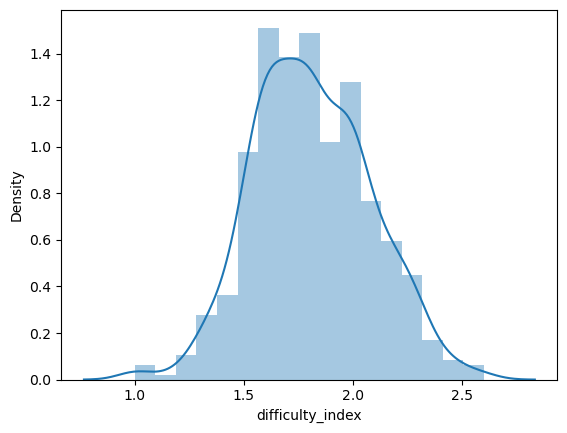

In [107]:
sns.distplot(resorts['difficulty_index'])

### Creation of the Dashboard

In [230]:
[x for x in list(resorts.select_dtypes('number').columns) if x not in ['ID','Latitude',
 'Longitude']]

['Price',
 'Highest point',
 'Lowest point',
 'Beginner slopes',
 'Intermediate slopes',
 'Difficult slopes',
 'Total slopes',
 'Longest run',
 'Snow cannons',
 'Surface lifts',
 'Chair lifts',
 'Gondola lifts',
 'Total lifts',
 'Lift capacity',
 'season_length',
 'slope_population_density',
 'difficulty_index']

global content

In [264]:
# need this for the month dropdown
months_of_year = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                      'September', 'October', 'November', 'December']
# choropleth map scope dictionary to map the values in our toggle to the values
# plotly takes in the argument
map_scope_dict = {
    'All': 'world',
    'Europe': 'europe', 
    'North America': 'north america',
    'South America': 'south america',
    'Asia': 'asia'}

fields_to_look_at_global = ['Price',
 'Highest point',
 'Lowest point',
 'Beginner slopes',
 'Intermediate slopes',
 'Difficult slopes',
 'Total slopes',
 'Longest run',
 'Snow cannons',
 'Surface lifts',
 'Chair lifts',
 'Gondola lifts',
 'Total lifts',
 'Lift capacity',
 'season_length',
 'slope_population_density',
 'difficulty_index']




global_content = html.Div([
    
    html.Br(),
    html.Br(),
    html.P("Which Month Do you want to Visit?"),
    dcc.Dropdown(
    
        id='month-dropdown',
        options = months_of_year + ['All'],
        value = ['All'],
        multi = True,
        className = 'dbc'
    ),
    
    html.Br(),
    dbc.Card([
        # row to house the headers for the toggles
        dbc.Row([dbc.Col(['Map Scope']), dbc.Col(['Choose Metric'])]),
        # row to house the toggles themselves
        dbc.Row([

            dbc.Col([

                dcc.RadioItems(

                    id='map-scope-toggle',
                    options = [{'label': label, 'value': value} for label, value in map_scope_dict.items()],
                    value = 'world',
                    inline = True
                )

            ]), 

            dbc.Col([

                dcc.RadioItems(

                    id='metric-toggle',
                    options = ['sum', 'mean', 'median'],
                    value = 'sum',
                    inline = True
                )

            ])
        ])
        
    ]),
    
    html.Br(),
    
    html.P("Choose Field to Analyse"),
    dcc.Dropdown(
    
        id='field-dropdown-global',
        options = fields_to_look_at_global,
        value = 'Total slopes'
    ),
    
    dcc.Graph(id='choropleth-global', 
              # init the hoverdata with frnce as the country
            hoverData={'points': [{'customdata': ['France']}]}),
    
    dbc.Card([dcc.Graph(id='resort-bar')])
])

resort content

In [267]:
resort_content = html.Div([
    
    html.Br(),
    html.Br(),
    html.P("Choose Resort Season Length (Months)"),
    dcc.RangeSlider(
    
        id='resort-length-slider',
        min = 0,
        max = 12,
        step = 3,
        value = [3,9]
    ),
    
    html.Hr(),
    
    html.P("Looking for Something in Particular?"),
    
    dcc.Dropdown(
    
        id='resort-content-fields',
        options = fields_to_look_at_global,
        value = 'Total slopes'
        
    ),
    
    html.Br(),
    dbc.Card([
        # row to house the headers for the toggles
        dbc.Row([dbc.Col(['Top N']), dbc.Col(['Top/Bottom']), dbc.Col([''])]),
        # row to house the toggles themselves
        dbc.Row([

            dbc.Col([

                dcc.RadioItems(

                    id='top-n-toggle',
                    options = [5,10,15,20],
                    value = 10,
                    inline = True
                )

            ]), 
            
            dbc.Col([

                dcc.RadioItems(

                    id='largest-smallest-toggle',
                    options = ['Largest', 'Smallest'],
                    value = 'Largest',
                    inline = True
                )

            ]),
            
            
            dbc.Col([

                dcc.RadioItems(

                    id='asc-desc-toggle',
                    options = ['Ascending', 'Descending'],
                    value = 'Descending',
                    inline = True
                )

            ]),
            
        ])
        
    ]),
    
    html.Br(), 
    dcc.Graph(id='resort-content-bar')
    
])




overall Layout

In [266]:
# initiate the css online sheet to connect the app to.
# This is for defualt styles

# download slate, we can always change later on
load_figure_template('SLATE')

# defualts all charts to yellow green blue scale!
px.defaults.color_continuous_scale = px.colors.diverging.RdYlGn

dbc_css = "https://cdn.jsdelivr.net/gh/AnnMarieW/dash-bootstrap-templates/dbc.min.css"

app = JupyterDash(__name__, 
                  # note this difference
                  external_stylesheets=[dbc.themes.SLATE, dbc_css] 
                 )


app.layout = html.Div(
    className = 'dbc' , 
    children = [
        
        html.H1("Worldwide Ski Resorts"),
        html.Hr(),
        html.P("Choose Price Range ($)"),
        dcc.RangeSlider(
            id = 'price-range',
            min = resorts['Price'].min(),
            max = resorts['Price'].max(),
            step = 10,
            value = [resorts['Price'].min(), resorts['Price'].max()]
        ),
        html.P("Choose Elevation Range (M)"),
        dcc.RangeSlider(
        
            id='elevation-range',
            min = 100,
            max = 4200,
            step = 200,
            value = [resorts['Highest point'].min() , resorts['Highest point'].max()],
            marks = {i : f"{i}" for i in range(100, 4200, 200)}
        ),
        html.Hr(),
        html.P("Various Ski Amenities"),
        dcc.Checklist(
        
            id='amenities-checklist',
            options = [{'label': 'Child Friendly', 'value': 'Child friendly'},
                    {'label': 'Snow Parks', 'value': 'Snowparks'},
                    {'label': 'Night Skiing','value': 'Nightskiing'},
                    {'label': 'Summer Skiing', 'value': 'Summer skiing'}],
            value = [],
            inline = True
            
        ),
        
        html.Br(),
        
        dcc.Tabs(id='tab-container', value='global-tab', children=[
            
            dcc.Tab(label='Global Statistics', value='global-tab', children=global_content),
            dcc.Tab(label='Top N Resorts', value='resort-tab', children=resort_content)
            
        ])
        
    ])





# global_callabacks


@app.callback(

    Output('choropleth-global', 'figure'),
    Output('resort-bar', 'figure'),
    Output('resort-content-bar', 'figure'),
    Input('price-range', 'value'),
    Input('elevation-range', 'value'),
    Input('amenities-checklist', 'value'),
    
    #tab 1
    Input('month-dropdown', 'value'),
    Input('map-scope-toggle', 'value'),
    Input('metric-toggle', 'value'),
    Input('field-dropdown-global', 'value'),
    Input('choropleth-global', 'hoverData'),
    
    # tab 2
    Input('resort-length-slider', 'value'),
    Input('resort-content-fields', 'value'),
    Input('top-n-toggle', 'value'),
    Input('asc-desc-toggle', 'value'),
    Input('largest-smallest-toggle', 'value')
)
def global_contents(price_list , elevation_list ,amenities, 
                    # tab1 below addd 
                    month_drop_list, map_scope, metric, field, hover_data,
                   # tab2 below added
                    season_length, resort_field, top_n , ascending_descending, 
                    largest_smallest):
    
    
    
    
    # check price and elevation
    resorts_price = resorts.query(f"{price_list[0]} <= Price <= {price_list[1]}")
    resorts_elevation = resorts_price.loc[(resorts_price['Highest point']
                                           .between(elevation_list[0], elevation_list[1]))]
    
    # amenities
    
    if amenities == []:
        
        resorts_amenity = resorts_elevation
        
    else:
        
        # filter statement will show all as true if the sum of the True/False
        # in the rows of the first statement is equal to the length of the amenities
        # list
        filter_statement = ((resorts[amenities] == 'Yes').sum(axis = 1) == len(amenities))
        
        resorts_amenity = resorts_elevation.loc[filter_statement]
        
        
    ## Tab1 - global_content
    
    # month of travel
    
    if 'All' in month_drop_list:
        
        resorts_month = resorts_amenity
    
    # we want to create a yes/no filter to filter out resorts that dont fall into any
    # of the months we have provided based off thier season
    else:
        # create a new field that acts as a boolean to show if any months fall within the 
        # season/seasons of the resort
        
        resorts_amenity['month_filter'] = (resorts_amenity['Season']
                                           # whether the month falls in the range is the first index of our above function
                                           .apply(lambda x: any(is_month_in_range_specific_dataset(y, x)[0] for y in month_drop_list)))
        
        resorts_month = resorts_amenity.query("month_filter == 1")
        
        
    country_by_field_metric = (resorts_month
                               .groupby('Country', as_index = False)
                               .agg({field : metric}))
    
    
    choro_fig = px.choropleth(
    
        country_by_field_metric,
        locations = 'Country',
        locationmode = 'country names',
        scope = map_scope,
        title = f'Countries by {metric} of {field}',
        color = field,
        hover_name = 'Country',
        custom_data = ['Country']
        
        
    )
    
    choro_fig.update_geos(bgcolor='lightgrey')
    choro_fig.update_layout(margin={"r":20,"t":50,"l":20,"b":20})
    
    
    # country name from the hover
    country_name = hover_data["points"][0]["customdata"][0]
    
    
    bar_fig = px.bar(
    
        (resorts_month.query("Country == @country_name")
         .sort_values('slope_population_density', ascending = False)),
        y = 'Resort',
        x = 'slope_population_density',
        color = 'difficulty_index',
        color_continuous_scale= ['green', 'lightblue', 'red'],
        range_color=(1, 3),
        title = f'Resort Slope Population Density and Difficulty in {country_name}',
        
    )
    
    bar_fig.update_xaxes(
    
        title = 'Slope Population Density'
    )
    
    
    
    ## Tab2 - Resort-content
    
    resorts_length = resorts_amenity.query(f"{season_length[0]} <= season_length <= {season_length[1]}")
    
    if largest_smallest == 'Largest':
        
        resorts_content_final = (resorts_length
                                         .nlargest(top_n , resort_field))
                
    else:
            
        resorts_content_final = (resorts_length
                                         .nsmallest(top_n , resort_field))


    
    
    
    
    
    if ascending_descending == 'Ascending':
        
        resorts_content_final = resorts_content_final.sort_values(resort_field, ascending = True)
        
        resort_fig = px.bar(
    
        resorts_content_final,
        y = 'Resort',
        x = resort_field,
        color = 'Country',
        color_discrete_sequence=px.colors.qualitative.Light24,
        title = f"{top_n} {largest_smallest} Resorts for {resort_field}"
    )
        
        resort_fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
        
    else:
        
        resorts_content_final = resorts_content_final.sort_values(resort_field, ascending = False)
        
        resort_fig = px.bar(
    
        resorts_content_final,
        y = 'Resort',
        x = resort_field,
        color = 'Country',
        color_discrete_sequence=px.colors.qualitative.Light24,
        title = f"{top_n} {largest_smallest} Resorts for {resort_field}"
    )
        
        resort_fig.update_layout(barmode='stack' , yaxis={'categoryorder':'total descending'})
        
        
    
    
    
    return choro_fig, bar_fig, resort_fig
    
        
    










app.run_server(debug = True , port = 5551 )

Dash is running on http://127.0.0.1:5551/

Dash app running on http://127.0.0.1:5551/
